# US in-patient billing data for 2011

This is a student exercise for the Thinkful Data Science Program.  The goal of this exercise is to practice pandas and pyplot functions.  I've chosed to experiment with data about in-patient billings in the US in the year 2011.  The workbook is organized as follows: 

* imports and data data clean-up
* view of a sample data row
* total payments & total medicare payments by state and zipcode
* observations on distribution of medicare payments by zipcode
* observations on the proportion of medicare vs. non-medicare payments by state
* observations on the relatioship between provider size and the proportion of payments made by medicare


## Imports & Data Clean-up

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#import data from local file - assumed to be in same directory as this workbook
#to get a copy of this data, go to...
# https://data.cms.gov/Medicare-Inpatient/Inpatient-Prospective-Payment-System-IPPS-Provider/97k6-zzx3
inpatient = pd.read_csv('inpatient_2011.csv')

#replace whitespaces with '_' as some of these column names have sneaky spaces
inpatient.columns = inpatient.columns.str.replace(' ', '_')

#add a few interesting calculated columns
inpatient["Total_Payments"] = ( inpatient["_Average_Total_Payments_"] 
                                       * inpatient["_Total_Discharges_"] )
inpatient["Total_Medicare_Payments"] = ( inpatient["Average_Medicare_Payments"] 
                                       * inpatient["_Total_Discharges_"] )
inpatient["Total_Non_Medicare_Payments"] = inpatient["Total_Payments"] - inpatient["Total_Medicare_Payments"] 
inpatient["Proportion_Paid_By_Medicare"] = ( inpatient["Average_Medicare_Payments"] 
                                            / inpatient["_Average_Total_Payments_"] )

#drop columns that I'm not interested in today
inpatient = inpatient.drop(columns=["DRG_Definition", "Provider_Street_Address", 
                                    "Hospital_Referral_Region_Description",
                                    "Provider_Name", "Provider_City"])


## Sample Row

In [5]:
inpatient.sample()

,Provider_Id,Provider_State,Provider_Zip_Code,_Total_Discharges_,_Average_Covered_Charges_,_Average_Total_Payments_,Average_Medicare_Payments,Total_Payments,Total_Medicare_Payments,Total_Non_Medicare_Payments,Proportion_Paid_By_Medicare
134744,150008,IN,46312,49,22589.02,10806.16,10072.77,529501.84,493565.73,35936.11,0.932132


## Total Payments & Total Medicare Payments by State

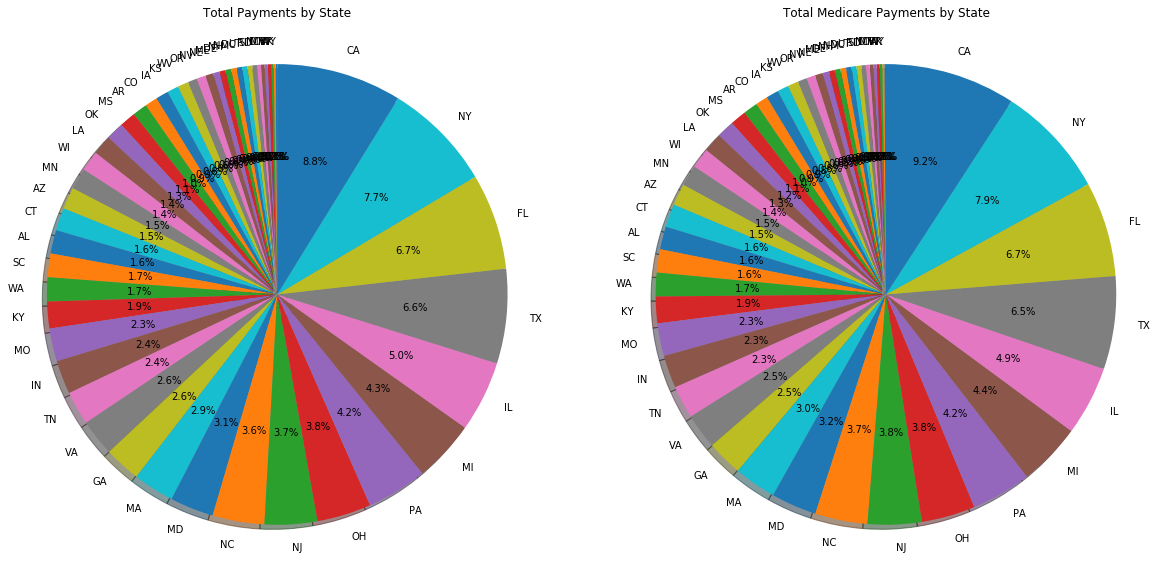

In [11]:
#pie charts showing total payments, total medicare payments by state

totals_by_state = inpatient.groupby('Provider_State').aggregate(np.sum)
sorted_totals_by_state = totals_by_state.sort_values(by=['Total_Payments'])
labels = sorted_totals_by_state.index
sizes = sorted_totals_by_state['Total_Payments']

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.pie(sorted_totals_by_state['Total_Payments'], labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Total Payments by State')

plt.subplot(1, 2, 2)
plt.pie(sorted_totals_by_state['Total_Medicare_Payments'], labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Total Medicare Payments by State')

plt.show()

### Observations:
The states with the most total payments are the same as states with the most medicare payments.  

## What's the distribution of medicare payments by zipcode?

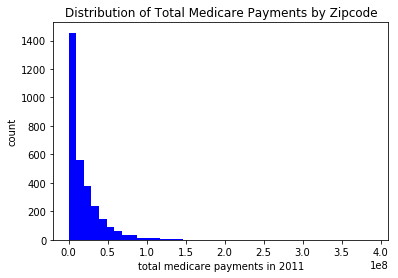

In [12]:
inpatient_by_zip = inpatient.groupby('Provider_Zip_Code').aggregate(np.sum)
plt.hist(inpatient_by_zip["Total_Medicare_Payments"], color='blue', bins=40)
plt.ylabel('count')
plt.xlabel('total medicare payments in 2011')
plt.title('Distribution of Total Medicare Payments by Zipcode')
plt.show()


### Observation
Most zip codes have very low medicare payment totals, while a few have dramatically higher totals. 

### Further research
Joining this data with zip code population data would be more interesting.  Population count is likely driving the variance, as could average age or average income.  

## What is the Proportion of Payments paid by Medicare by State

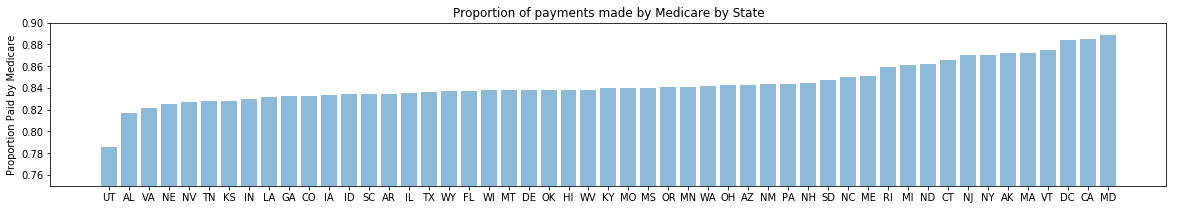

In [7]:
inpatient_by_state = inpatient.groupby('Provider_State').aggregate(np.mean)
sorted_inpatient_by_state = inpatient_by_state.sort_values(by=['Proportion_Paid_By_Medicare'])
ind = np.arange(sorted_inpatient_by_state.shape[0])
plt.figure(figsize=(20, 3))
plt.bar(ind, sorted_inpatient_by_state["Proportion_Paid_By_Medicare"], alpha = .5)
plt.ylim([0.75, 0.9])
plt.ylabel('Proportion Paid by Medicare')
plt.xticks(ind, sorted_inpatient_by_state.index)
plt.title('Proportion of payments made by Medicare by State')
plt.show()

### Observation
Looks like New England, California, and a few others have more of their medical costs paid by Medicare compared to the rest of the country. 

### Further research
Joining this data with political party affiliation might be interesting.  Also with income or age data.  I wonder what might be the driving force for the dramatically lower medicare proportion in UT? 

## Relationship between provider size and proportion of payments made by medicare

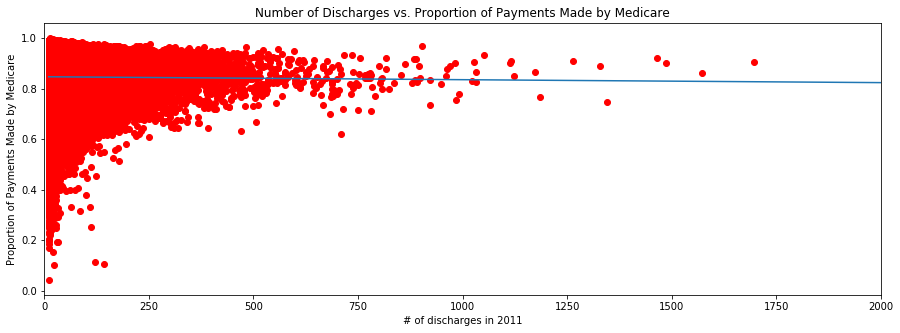

In [17]:
x = inpatient['_Total_Discharges_']
y = inpatient['Proportion_Paid_By_Medicare']

plt.figure(figsize=(15, 5))
plt.scatter(x, y, color="red")
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.title("Number of Discharges vs. Proportion of Payments Made by Medicare")
plt.ylabel("Proportion of Payments Made by Medicare")
plt.xlabel("# of discharges in 2011")
plt.xlim([0, 2000])
plt.show()

### Observations
At first glance, without the best fit line, it looks like providers (fewer than 250 discharges in 2011) are much more likely to have a lower proportion of payments made by Medicare (<60%).  If that were true, then the best fit line would more steeply slope up from left to right.  Instead ita actually slopes slightly down from left to right.  That could be because overlapping markers hide marker density.  

Of course i could test that by inspecting the data more, but since we're learning about plotting, let's make another plat that makes the truth clearer.  I'll reduce market size and reduce the alpha of the scatter points so that point density is more apparent. 


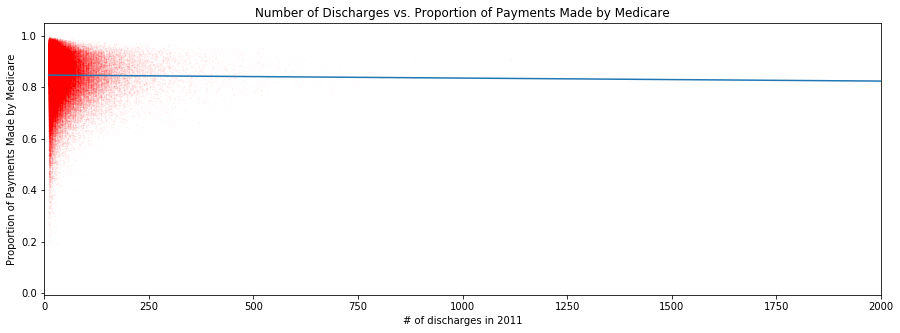

In [46]:
sorted_inp = inpatient.sort_values(by=['_Total_Discharges_'])
x = sorted_inp['_Total_Discharges_']
y = sorted_inp['Proportion_Paid_By_Medicare']

plt.figure(figsize=(15, 5))
plt.scatter(x, y, color="red", s = .5, alpha = .03)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.title("Number of Discharges vs. Proportion of Payments Made by Medicare")
plt.ylabel("Proportion of Payments Made by Medicare")
plt.xlabel("# of discharges in 2011")
plt.xlim([0, 2000])
plt.show()

Smaller markers make a big difference in the explanaroty power of the plot. 

This is a much clearer picture of the number of providers of different sizes and medicare payment proportions.  The prior picture exagerated the number of larger providers and exagerated the number of smaller providers with low medicare payment proportions.  The downward sloping best-fit line makes more intuitive sense given this view. 